In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import gc
gc.collect()

2828

In [20]:
torch.cuda.empty_cache()  

In [21]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

73738240
102760448


In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
for module, param in zip(model_ft.modules(), model_ft.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False
        
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft.load_state_dict(torch.load('feb_resize_models/model_weight/corn_model_resize_wd.pth'))
model_ft.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_transforms = transforms.Compose([
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'feb_crop_image/corn_dataset'
image_datasets = datasets.ImageFolder(os.path.join(data_dir), image_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4,
                                             shuffle=True, num_workers=4)

dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [24]:
image_data_dir = data_dir
image_data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_data_loader = torch.utils.data.DataLoader(datasets.ImageFolder(image_data_dir, image_data_transforms), batch_size=4,shuffle=True, num_workers=4)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

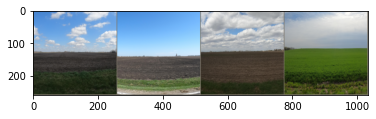

In [27]:
# Get a batch of training data
inputs, classes = next(iter(image_data_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [28]:
# y_pred = []
# y_true = []

# # iterate over test data
# for inputs, labels in image_data_loader:
#         output = model_ft(inputs.to(device)) # Feed Network

#         output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#         y_pred.extend(output) # Save Prediction
        
#         labels = labels.data.cpu().numpy()
#         y_true.extend(labels) # Save Truth

# # constant for classes
# classes = ('grass', 'high_tillage', 'low_tillage', 'no_tillage')

In [29]:
# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# print(cf_matrix)
# df_cm = pd.DataFrame((cf_matrix.T/np.sum(cf_matrix, axis=1)).T, index = [i for i in classes],
#                      columns = [i for i in classes])
# # plt.title("Confusion matrix: Tillage Classification")
# ax = plt.axes()
# print(df_cm)
# ax.set_title('Confusion Matrix: Tillage Classification')
# sn.heatmap(df_cm, ax=ax, annot=True)

In [30]:
import PIL

image_dir = "feb_crop_image/corn_dataset"
# image_dir = "feb_crop_geotagging"
class_map = {
    0: 'grass',
    1: 'high_tillage',
    2: 'low_tillage',
    3: 'no_tillage'
}
for phase in os.listdir(image_dir):
    for classes in os.listdir(image_dir + "/" + phase):
        for file in os.listdir(image_dir + "/" + "/" + phase + "/" + classes):
            fullpath = image_dir + "/" + "/" + phase + "/" + classes + "/" + file
            im = PIL.Image.open(fullpath)
            image = image_data_transforms(im)
            image = image.unsqueeze(0)
            image = image.to(device)
            out = model_ft(image)
            output = class_map[(torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()[0]]
            if output != classes:
                print("Full path: ", fullpath)
                print("True: ", classes)
                print("Predicted: ", output)
                print("Probability: ", torch.exp(out).data.cpu().numpy()[0])
                # plt.figure()
                # plt.imshow(im)
                # plt.show()
                print("\n")



Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0079930.JPG
True:  low_tillage
Predicted:  high_tillage
Probability:  [4.6386472e-03 3.3351944e+01 1.6080364e+01 1.9916257e-01]


Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0079343.JPG
True:  low_tillage
Predicted:  no_tillage
Probability:  [1.8132655e-02 2.6663011e-01 6.1986561e+00 1.9720242e+01]


Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0136549.JPG
True:  low_tillage
Predicted:  high_tillage
Probability:  [1.1429793e-02 3.6935604e+01 6.5779681e+00 1.9168741e-01]


Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0136444.JPG
True:  low_tillage
Predicted:  high_tillage
Probability:  [8.8231927e-03 3.3135338e+01 6.9956326e+00 1.8107261e-01]


Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0058495.JPG
True:  low_tillage
Predicted:  no_tillage
Probability:  [0.33909544 0.21942008 2.6564639  4.116018  ]


Full path:  feb_crop_image/corn_dataset//val/low_tillage/G0134305.JPG
True: 